# Imports

In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # either 3 or 6

from data_generators import *
import utils
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import copy

torch.__version__

'1.8.1'

In [25]:
# setup generators / data loaders for training and validation

# we'll make the training data loader in the training loop,
# since we need to update some of the examples used each epoch
train_gen = TrainGenerator("mouse", "CTCF")

source_val_gen = ValGenerator("mouse", "CTCF", batchsize=1000)
# using a batch size of 1 here because the generator returns
# many examples in each batch
source_val_data_loader = DataLoader(source_val_gen, batch_size = 1, shuffle = True)

target_val_gen = ValGenerator("human", "CTCF", batchsize=1000)
target_val_data_loader = DataLoader(target_val_gen, batch_size = 1, shuffle = True)

1365


# Model Training And Evaluation

In [3]:
class BasicModel(torch.nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        self.input_seq_len = 500
        num_conv_filters = 240
        lstm_hidden_units = 32
        fc_layer1_units = 1024
        fc_layer2_units = 512
        
        # Defining the layers to go into our model
        # (see the forward function for how they fit together)
        self.conv = torch.nn.Conv1d(4, num_conv_filters, kernel_size=20, padding=0)
        self.relu = torch.nn.ReLU()

        # We'll store performance metrics during training in these lists
        self.train_loss_by_epoch = []
        self.source_val_loss_by_epoch = []
        self.source_val_auprc_by_epoch = []
        self.target_val_loss_by_epoch = []
        self.target_val_auprc_by_epoch = []

        # We'll record the best model we've seen yet each epoch
        self.best_state_so_far = self.state_dict()
        self.best_auprc_so_far = 1

    def forward(self, X):
        return (self.conv(X))
        
    def validation(self, data_loader):
        # only run this within torch.no_grad() context!
        losses = []
        preds = []
        labels = []
        for seqs_onehot_batch, labels_batch in data_loader:
            # push batch through model, get predictions, calculate loss
            preds_batch = self(seqs_onehot_batch.squeeze().cuda())
            labels_batch = labels_batch.squeeze()
            loss_batch = self.loss(preds_batch, labels_batch.cuda())
            losses.append(loss_batch.item())

            # storing labels + preds for auPRC calculation later
            labels.extend(labels_batch.detach().numpy())  
            preds.extend(preds_batch.cpu().detach().numpy())
            
        return np.array(losses), np.array(preds), np.array(labels)

    def convolve(self, data_loader):
        # only run this within torch.no_grad() context!

        # DEBUG
        for seqs_onehot_batch, labels_batch in data_loader:
            print('seqs_onehot_batch:',seqs_onehot_batch.shape)
            print('labels_batch:', labels_batch.shape)
            break
            
        features = []
        for seqs_onehot_batch, labels_batch in data_loader:
            # push batch through model, get predictions, calculate loss
            features_batch = self(seqs_onehot_batch.squeeze().cuda())
            print(features_batch.shape)
            # storing labels + preds for auPRC calculation later
            features.extend(features_batch.cpu().detach().numpy())
#             features.extend(features_batch.cpu().detach().numpy())
        features_all = np.array(features)
        print('features:',features_all.shape)
        return features_all # maybe hold off on converting to numpy to run torch.cov on the gpu?
    
    def loader_to_generator(self, data_loader):
        for batch in data_loader:
            yield batch
    
    def get_cov(self, data_loader, nbatch=100):
        """
        seqs_onehot_batch : (1, batchsize, input_seq_len) [1, 1000, 4, 500]
        convolved_batch : (batchsize, num_conv_filters, input_seq_len - padding) [1000, 240, 481]
        labels_batch : (1, batchsize) [1, 1000]
        cov_batch : ()
        """
        covariances = []
        generator = self.loader_to_generator(data_loader)
        for i in range(nbatch):
            seqs_onehot_batch, labels_batch = next(generator)
            # push batch through model, get predictions, calculate loss
            convolved_batch = self(seqs_onehot_batch.squeeze().cuda())
            cov_batch = np.cov(torch.max(convolved_batch, 2).values.T.cpu().detach().numpy())
            covariances.append(cov_batch)
        print(f'cov of batch {i-nbatch+1} to {i+1}')
        return covariances

In [26]:
model = BasicModel()
model.cuda()
print('Getting covariances for source and target...')

src_cov0 = model.get_cov(source_val_data_loader)
#zero_diagonal_src_cov0 = zero_out_diagonal_matrices(src_cov0)

src_cov1 = model.get_cov(source_val_data_loader)
#zero_diagonal_src_cov1 = zero_out_diagonal_matrices(src_cov1)

tgt_cov0 = model.get_cov(target_val_data_loader)
#zero_diagonal_tgt_cov0 = zero_out_diagonal_matrices(tgt_cov0)

tgt_cov1 = model.get_cov(target_val_data_loader)
#zero_diagonal_tgt_cov1 = zero_out_diagonal_matrices(tgt_cov1)


Getting covariances for source and target...
cov of batch 0 to 100
cov of batch 0 to 100
cov of batch 0 to 100
cov of batch 0 to 100


In [27]:
def zero_out_diagonal_matrices(cov_matrices):
    zeroed_out_diagonal_matrices = []
    cov_matrices_copy = copy.deepcopy(cov_matrices)
    for matrix in cov_matrices_copy:
        np.fill_diagonal(matrix, 0)
        zeroed_out_diagonal_matrices.append(matrix)
    return zeroed_out_diagonal_matrices

model.cpu()

zero_diagonal_src_cov0 = zero_out_diagonal_matrices(src_cov0)
zero_diagonal_src_cov1 = zero_out_diagonal_matrices(src_cov1)
zero_diagonal_tgt_cov0 = zero_out_diagonal_matrices(tgt_cov0)
zero_diagonal_tgt_cov1 = zero_out_diagonal_matrices(tgt_cov1)

In [28]:
norm_diff = lambda A, B: [np.linalg.norm(a - b) for (a,b) in zip(A,B)]

mm = norm_diff(src_cov0, src_cov1)
mm_no_diag = norm_diff(zero_diagonal_src_cov0, zero_diagonal_src_cov1)

hm = norm_diff(src_cov0, tgt_cov0)
hm_no_diag = norm_diff(zero_diagonal_src_cov0, zero_diagonal_tgt_cov0)

hh = norm_diff(tgt_cov0, tgt_cov1)
hh_no_diag = norm_diff(zero_diagonal_tgt_cov0, zero_diagonal_tgt_cov1)

same = norm_diff(tgt_cov0, tgt_cov0)
len(tgt_cov1)

#max_mm_no_diag = get_conv_filters(zero_diagonal_src_cov0, zero_diagonal_src_cov1)
#max_hm_no_diag = get_conv_filters(zero_diagonal_src_cov0, zero_diagonal_tgt_cov0)
#max_hh_no_diag = get_conv_filters(zero_diagonal_tgt_cov0, zero_diagonal_tgt_cov1)

100

In [29]:
def get_conv_filters(first, second):
#     src_cov0, tgt_cov0
#     src_cov1, tgt_cov1 (2nd batch)
    norm_diff = lambda A, B: [np.abs(a - b) for (a,b) in zip(A,B)]
    a = norm_diff(first, second)
#     print(a)
    mxm = a[0][0][0]
    sol = []
    for x in a:
        r = 0
        for y in x:
            r += 1
            c = 0
            for z in y:
                c += 1
                if z > mxm and c != r:
                    print(z, r, c)
                    mxm = z
                    current = [r, c]
        sol.append(current)
    return sol
#         print(x, x.shape)
#         y = max(x)
#         print('y', y)
#         [b, c] = find(x==y)
#         print(b)
#     for argmax(norm_diff)

print(get_conv_filters(src_cov0, tgt_cov0))

0.0008730547803882711 1 24
0.001304718786225064 1 46
0.0015956478546297077 1 141
0.0018875029923178114 24 220
0.0018924638520744527 46 85
0.0019333849279618068 55 169
0.0022014396947418633 131 145
0.0023458076388298463 16 220
0.002370104407059293 16 145
0.002603199068719037 16 97
0.0026277189720019414 68 85
[[131, 145], [131, 145], [16, 220], [16, 220], [16, 220], [16, 220], [16, 220], [16, 220], [16, 220], [16, 220], [16, 220], [16, 220], [16, 220], [16, 220], [16, 220], [16, 145], [16, 145], [16, 145], [16, 145], [16, 145], [16, 145], [16, 145], [16, 145], [16, 145], [16, 145], [16, 145], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [16, 97], [68, 85], [68, 85], [68, 85], [68, 85], [6

In [30]:
def get_conv_filters(first, second):
#     src_cov0, tgt_cov0
#     src_cov1, tgt_cov1 (2nd batch)
    norm_diff = lambda A, B: [np.abs(a - b) for (a,b) in zip(A,B)]
    a = norm_diff(first, second)
#     print(a)
    mxm = a[0][0][0]
    sol = []
    for x in a:
        r = 0
        for y in x:
            r += 1
            c = 0
            for z in y:
                c += 1
                if z > mxm:
                    print(z, r, c)
                    mxm = z
                    current = [r, c]
        sol.append(current)
    return sol
#         print(x, x.shape)
#         y = max(x)
#         print('y', y)
#         [b, c] = find(x==y)
#         print(b)
#     for argmax(norm_diff)

print(get_conv_filters(src_cov0, tgt_cov0))

0.0008730547803882711 1 24
0.001304718786225064 1 46
0.0015956478546297077 1 141
0.0028117164002730176 7 7
0.0031462645129002468 85 85
0.0031764525263168007 131 131
0.0032641014285384904 7 7
0.003442769440430654 131 131
[[7, 7], [7, 7], [7, 7], [85, 85], [85, 85], [85, 85], [85, 85], [85, 85], [85, 85], [85, 85], [85, 85], [85, 85], [85, 85], [85, 85], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [7, 7], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131, 131], [131,

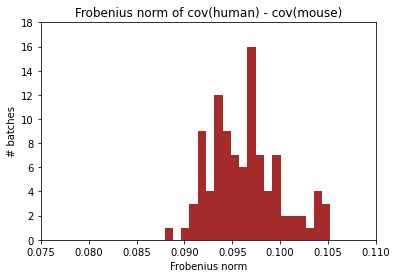

In [73]:
plt.hist(hm, bins=20, color='brown')
plt.title('Frobenius norm of cov(human) - cov(mouse)')
plt.xlim([0.075, 0.11])
plt.ylim([0, 18])
#plt.figure(figsize=(24, 6), dpi=80)
plt.xlabel('Frobenius norm')
plt.ylabel('# batches')
plt.savefig('cov-hm.jpg')

In [33]:
diff_matrix = lambda A, B: [np.abs(a - b) for (a,b) in zip(A,B)]

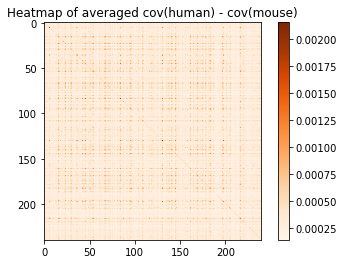

In [34]:
hm_matrices = diff_matrix(src_cov0, tgt_cov0)
hm_matrix_avg = sum(hm_matrices)/len(hm_matrices)

plt.title('Heatmap of averaged cov(human) - cov(mouse)')
plt.imshow(hm_matrix_avg, cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.show()

Text(0, 0.5, '# batches')

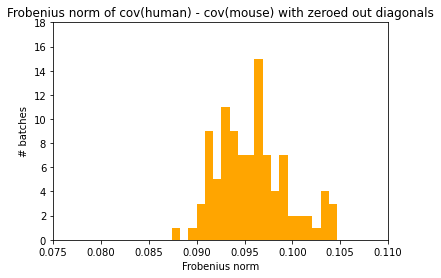

In [67]:
plt.hist(hm_no_diag, bins=20, color='orange')
plt.title('Frobenius norm of cov(human) - cov(mouse) with zeroed out diagonals')
plt.xlim([0.075, 0.11])
plt.ylim([0, 18])
plt.xlabel('Frobenius norm')
plt.ylabel('# batches')

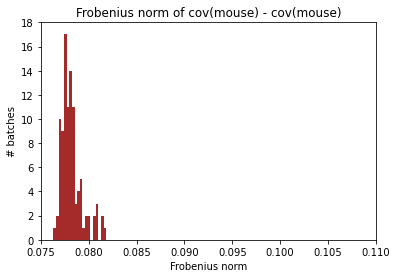

In [74]:
plt.hist(mm, bins=20, color='brown')
plt.title('Frobenius norm of cov(mouse) - cov(mouse)')
plt.xlim([0.075, 0.11])
plt.ylim([0, 18])
plt.xlabel('Frobenius norm')
plt.ylabel('# batches')
plt.savefig('cov-mm.jpg')

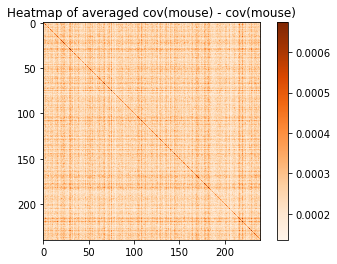

In [39]:
mm_matrices = diff_matrix(src_cov0, src_cov1)
mm_matrix_avg = sum(mm_matrices)/len(mm_matrices)

plt.title('Heatmap of averaged cov(mouse) - cov(mouse)')
plt.imshow(mm_matrix_avg, cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.show()

Text(0, 0.5, '# batches')

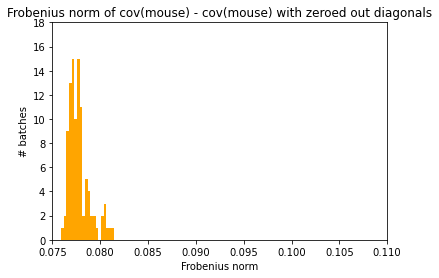

In [77]:
plt.hist(mm_no_diag, bins=20, color='orange')
plt.title('Frobenius norm of cov(mouse) - cov(mouse) with zeroed out diagonals')
plt.xlim([0.075, 0.11])
plt.ylim([0, 18])
plt.xlabel('Frobenius norm')
plt.ylabel('# batches')

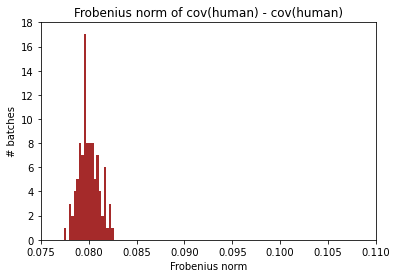

In [76]:
plt.hist(hh, bins=20, color='brown')
plt.title('Frobenius norm of cov(human) - cov(human)')
plt.xlim([0.075, 0.11])
plt.ylim([0, 18])
plt.xlabel('Frobenius norm')
plt.ylabel('# batches')
plt.savefig('cov-hh.jpg')

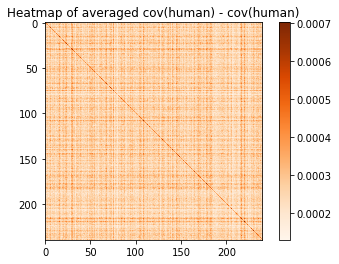

In [52]:
hh_matrices = diff_matrix(tgt_cov0, tgt_cov1)
hh_matrix_avg = sum(hh_matrices)/len(hh_matrices)

plt.title('Heatmap of averaged cov(human) - cov(human)')
plt.imshow(hh_matrix_avg, cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.show()

Text(0, 0.5, '# batches')

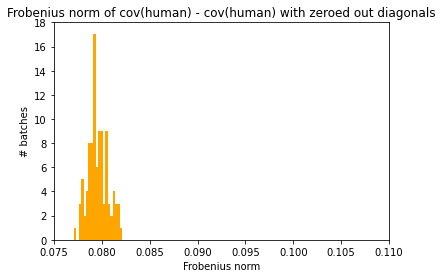

In [71]:
plt.hist(hh_no_diag, bins=20, color='orange')
plt.title('Frobenius norm of cov(human) - cov(human) with zeroed out diagonals')
plt.xlim([0.075, 0.11])
plt.ylim([0, 18])
plt.xlabel('Frobenius norm')
plt.ylabel('# batches')

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <BarContainer object of 20 artists>)

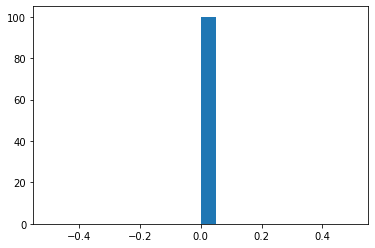

In [44]:
plt.hist(same, bins=20)

In [45]:
print(f'human-human ~ N({round(np.mean(hh),4)}, {round(np.std(hh),4)}^2)')
print(f'human-mouse ~ N({round(np.mean(hm),4)}, {round(np.std(hm),4)}^2)')
print(f'mouse-mouse ~ N({round(np.mean(mm),4)}, {round(np.std(mm),4)}^2)')

human-human ~ N(0.08, 0.0011^2)
human-mouse ~ N(0.0965, 0.0037^2)
mouse-mouse ~ N(0.0782, 0.0011^2)
